In [1]:
##Mount Google Drive to Colab VM

from google.colab import drive
drive.mount('/content/drive')

##Navigate to root working folder
%cd /content/drive/My Drive/Springboard/

Mounted at /content/drive
/content/drive/My Drive/Springboard


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import CategoricalNB
from imblearn.over_sampling import SMOTE

In [3]:
sns.set(font_scale = 1.5)

In [4]:
#Quickly redoing Data Wrangling to include more observations and features
X = pd.read_csv('SecondCapstone/data/training_set_features.csv', index_col='respondent_id')  # import training set of data
y = pd.read_csv('SecondCapstone/data/training_set_labels.csv', index_col='respondent_id')  #  import result data
df = X.join(y) #full data set

X.fillna('No Answer', inplace=True) #Since all Data is categorical setting all Null values to their own category
X = X.drop(columns=['employment_occupation', 'employment_industry', 'hhs_geo_region'])# The data in these features are arbitrary values whose corresponding information isn't given so they're basically useless to us
X = pd.get_dummies(X) #One Hot Encoding
X = X.astype('int')  #Assigning all values to Integer datatype for consistency, All ovservations are boolean

#renaming columns to avoid issues with XGBoost later on, XGBoost can't have '<' or ',' in the feature names
X.rename(columns={'education_< 12 Years':'education_less_than_12y','income_poverty_<= $75,000, Above Poverty':'income_poverty_less_than_or_equal_75000_above_poverty','income_poverty_> $75,000':'income_poverty_greater_than_75000' }, inplace=True)

y_h = y.drop(columns='seasonal_vaccine') #Separating Target into h1n1 and seasonal, I'll model each individually
y_s = y.drop(columns='h1n1_vaccine')

X_h = X.join(y_s) #adding target data for other vaccine, adding seasonal as a feature to target h1n1 and vice versa
X_s = X.join(y_h)

In [5]:
data_corr=df.corr()

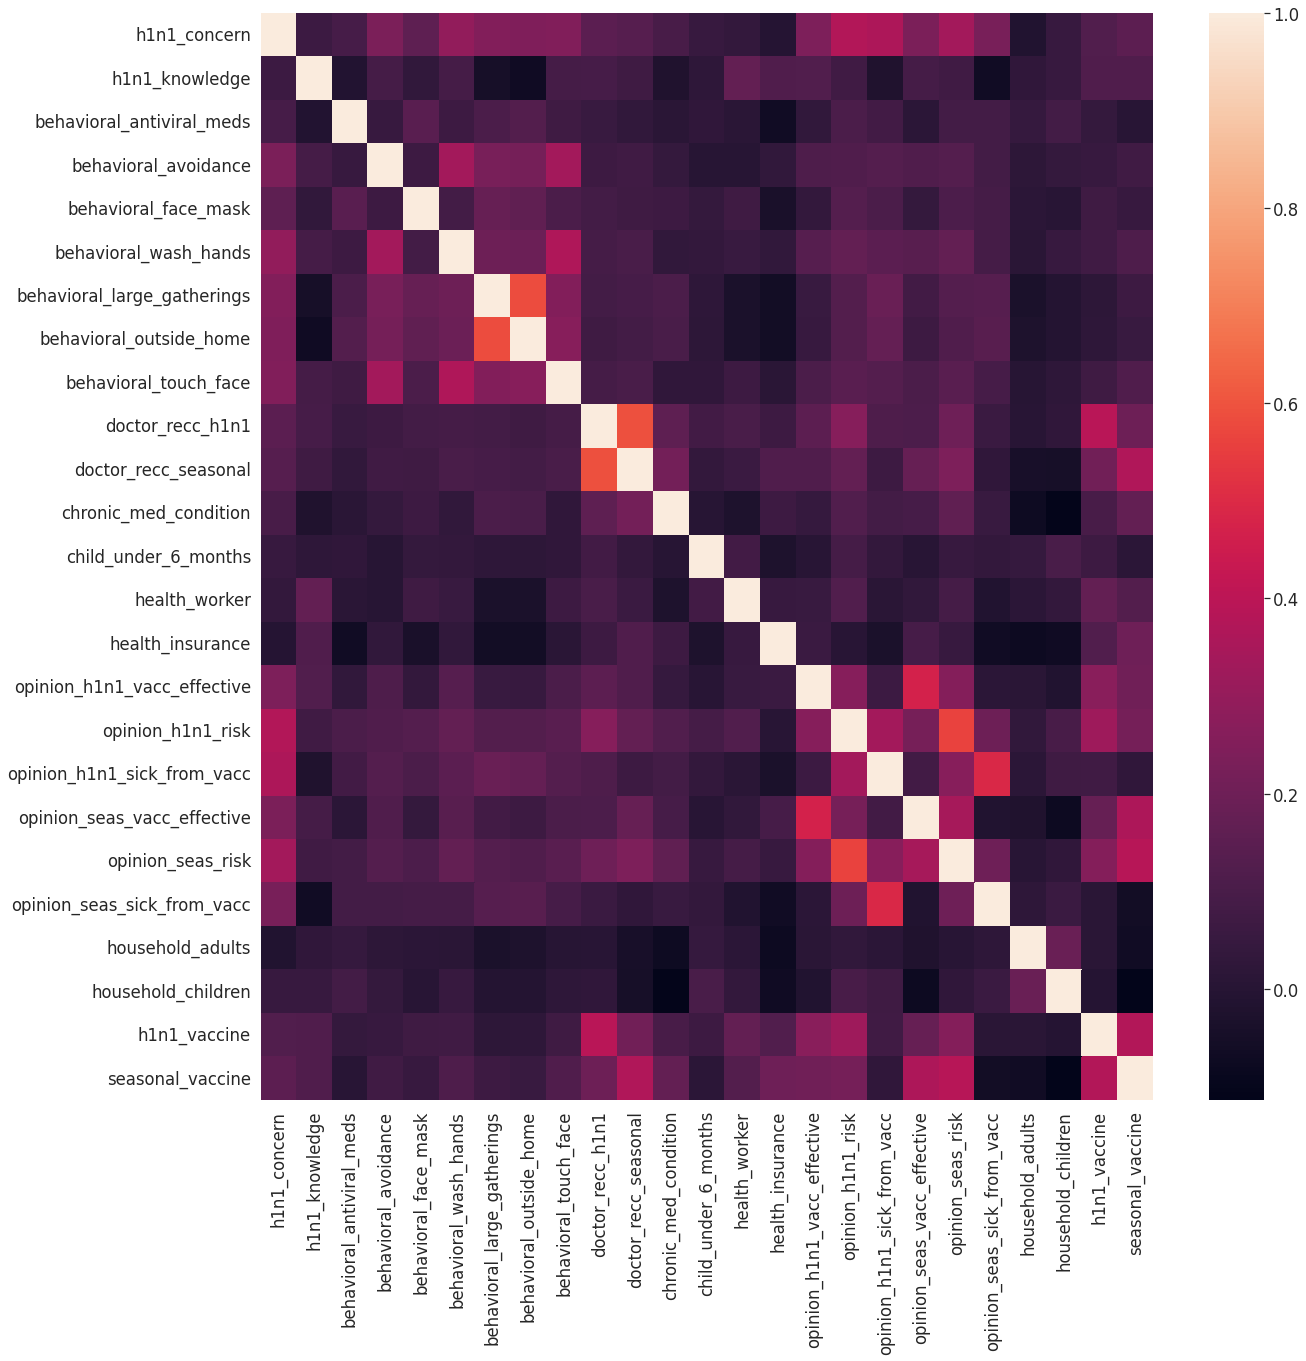

In [6]:
plt.figure(figsize=(20,20))
sns.heatmap(data_corr)

In [7]:
#Correlations before Dummy encoding
#Storing only correlations greater than 20%  or less than -20% to graph
h1n1_corr = data_corr[['h1n1_vaccine']][(data_corr['h1n1_vaccine'] > 0.2) | (data_corr['h1n1_vaccine'] < -0.2)].sort_values(['h1n1_vaccine'], ascending=False)
h1n1_corr.drop('h1n1_vaccine', inplace=True)
h1n1_corr_features = h1n1_corr.index
print(h1n1_corr)

seasonal_corr = data_corr[['seasonal_vaccine']][(data_corr['seasonal_vaccine'] > 0.2) | (data_corr['seasonal_vaccine'] < -0.2)].sort_values(['seasonal_vaccine'], ascending=False)
seasonal_corr.drop('seasonal_vaccine', inplace=True)
print(seasonal_corr)

                             h1n1_vaccine
doctor_recc_h1n1                 0.393890
seasonal_vaccine                 0.377143
opinion_h1n1_risk                0.323265
opinion_h1n1_vacc_effective      0.269347
opinion_seas_risk                0.258571
doctor_recc_seasonal             0.209864
                             seasonal_vaccine
opinion_seas_risk                    0.390106
h1n1_vaccine                         0.377143
doctor_recc_seasonal                 0.369190
opinion_seas_vacc_effective          0.361875
opinion_h1n1_risk                    0.216625
opinion_h1n1_vacc_effective          0.205072
health_insurance                     0.200858


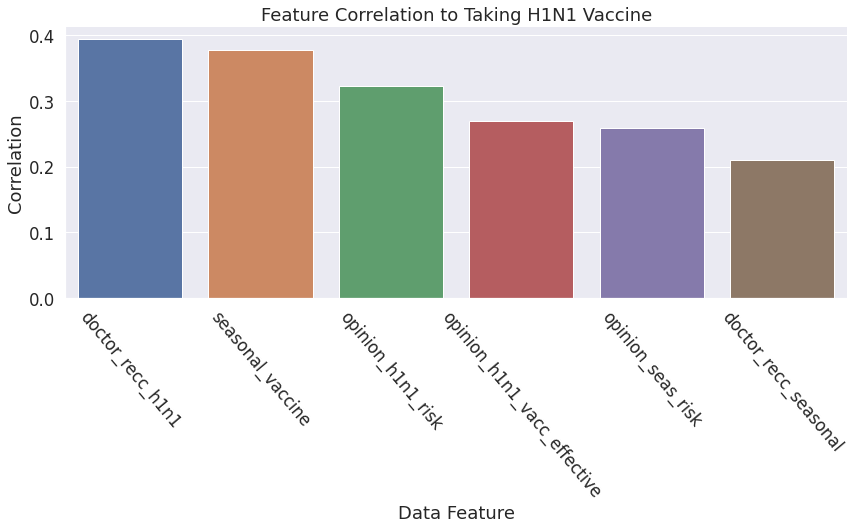

In [8]:
sns.catplot(x='index', y='h1n1_vaccine', kind='bar', height=5, aspect=2.5, data=h1n1_corr.reset_index()).set_xticklabels(rotation=-50)
plt.title("Feature Correlation to Taking H1N1 Vaccine")
plt.ylabel('Correlation')
plt.xlabel('Data Feature')
plt.show()

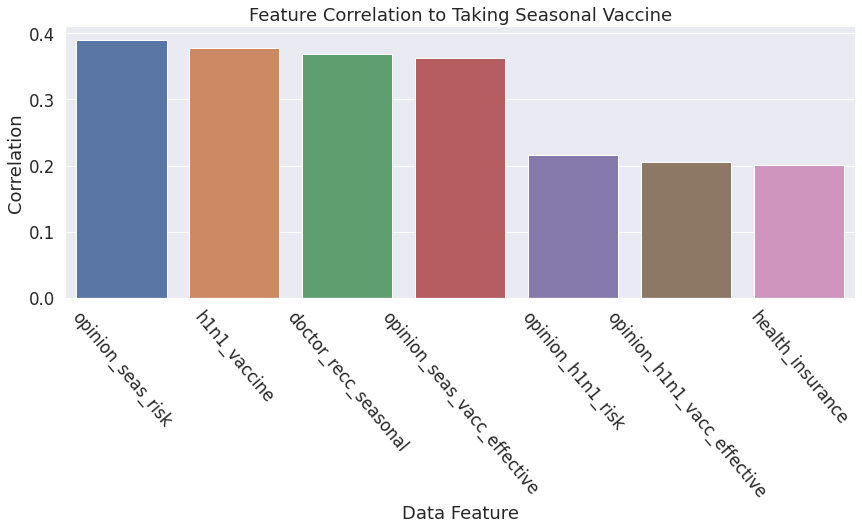

In [9]:
sns.catplot(x='index', y='seasonal_vaccine', kind='bar', height=5, aspect=2.5, data=seasonal_corr.reset_index()).set_xticklabels(rotation=-50)
plt.title("Feature Correlation to Taking Seasonal Vaccine")
plt.ylabel('Correlation')
plt.xlabel('Data Feature')
plt.show()

In [10]:
#Correlations after Dummy encoding
data_corr_d=X_h.join(y_h).corr()

#Storing only correlations greater than 20%  or less than -20% to graph
h1n1_corr_d = data_corr_d[['h1n1_vaccine']][(data_corr_d['h1n1_vaccine'] > 0.2) | (data_corr_d['h1n1_vaccine'] < -0.2)].sort_values(['h1n1_vaccine'], ascending=False)
h1n1_corr_d.drop('h1n1_vaccine', inplace=True)
print(h1n1_corr_d)

seasonal_corr_d = data_corr_d[['seasonal_vaccine']][(data_corr_d['seasonal_vaccine'] > 0.2) | (data_corr_d['seasonal_vaccine'] < -0.2)].sort_values(['seasonal_vaccine'], ascending=False)
seasonal_corr_d.drop('seasonal_vaccine', inplace=True)
print(seasonal_corr_d)

                                 h1n1_vaccine
doctor_recc_h1n1_1.0                 0.394086
seasonal_vaccine                     0.377143
opinion_h1n1_vacc_effective_5.0      0.284802
health_insurance_1.0                 0.244975
opinion_h1n1_risk_4.0                0.220946
doctor_recc_seasonal_1.0             0.218976
opinion_h1n1_risk_1.0               -0.200887
health_insurance_No Answer          -0.224759
doctor_recc_h1n1_0.0                -0.295792
                                 seasonal_vaccine
h1n1_vaccine                             0.377143
opinion_seas_vacc_effective_5.0          0.370035
doctor_recc_seasonal_1.0                 0.360696
opinion_seas_risk_4.0                    0.250813
age_group_65+ Years                      0.244830
opinion_seas_risk_1.0                   -0.275703
doctor_recc_seasonal_0.0                -0.303079


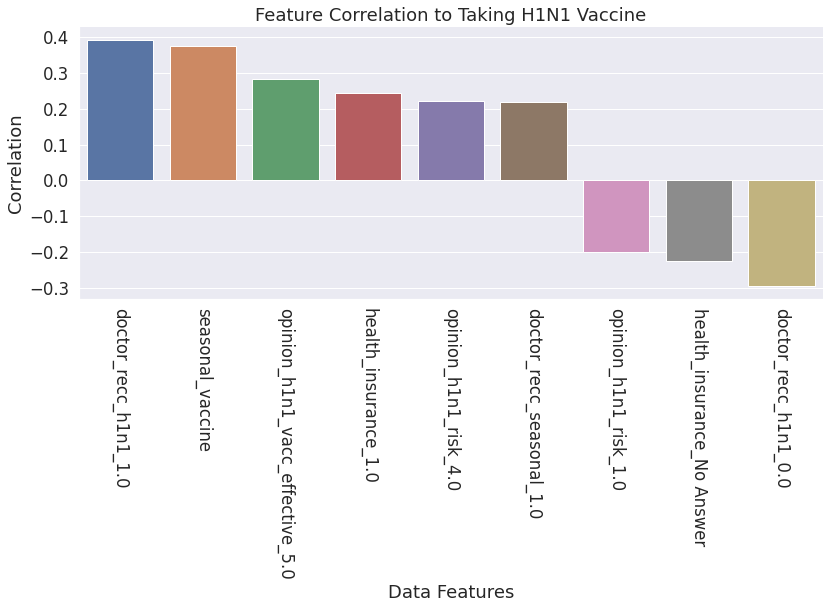

In [11]:
sns.catplot(x='index', y='h1n1_vaccine', kind='bar', height=5, aspect=2.5, data=h1n1_corr_d.reset_index()).set_xticklabels(rotation=-90)
plt.title("Feature Correlation to Taking H1N1 Vaccine")
plt.ylabel('Correlation')
plt.xlabel('Data Features')
plt.show()

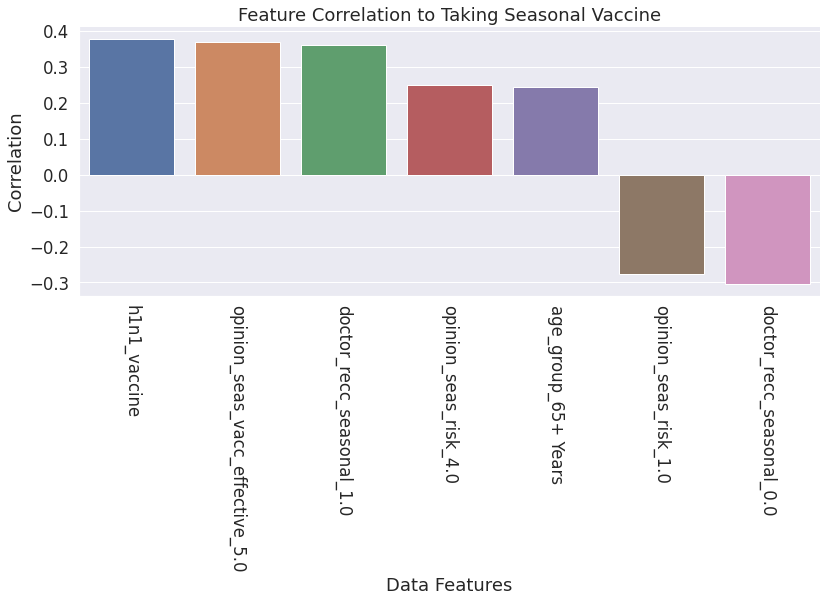

In [12]:
sns.catplot(x='index', y='seasonal_vaccine', kind='bar', height=5, aspect=2.5, data=seasonal_corr_d.reset_index()).set_xticklabels(rotation=-90)
plt.title("Feature Correlation to Taking Seasonal Vaccine")
plt.ylabel('Correlation')
plt.xlabel('Data Features')
plt.show()

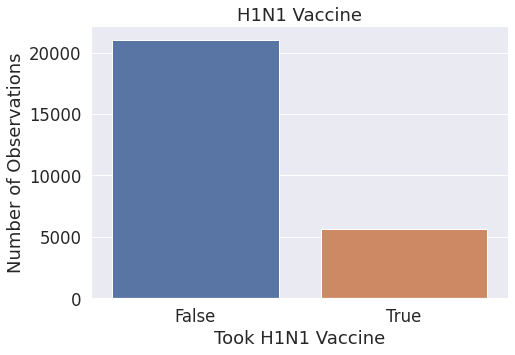

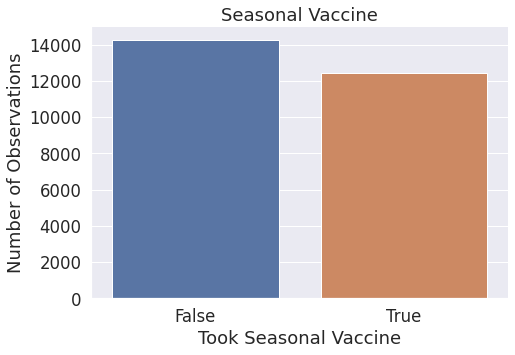

In [15]:
sns.catplot(x='h1n1_vaccine', kind='count', height=5, aspect=1.5, data=df).set_xticklabels(['False', 'True'])
plt.title("H1N1 Vaccine")
plt.ylabel("Number of Observations")
plt.xlabel("Took H1N1 Vaccine")
plt.show()

sns.catplot(x='seasonal_vaccine', kind='count', height=5, aspect=1.5, data=df).set_xticklabels(['False', 'True'])
plt.title("Seasonal Vaccine")
plt.ylabel("Number of Observations")
plt.xlabel("Took Seasonal Vaccine")
plt.show()